In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Extras needed
import time
import math
from utils import *

# Data Genration Functions , Loss for Base Estimator and training and test loops

In [2]:
def generate_train_test_split(count: int, dim: int, n: int, device: torch.device, coord_max: float, test_size: float = 0.2, seed: int = 42):
    all_batches = generate_vector_batches(count, dim, n, device, coord_max, seed)
    labels = torch.arange(count)  # Placeholder labels if needed

    train_indices, test_indices = train_test_split(range(count), test_size=test_size, random_state=seed)
    train_batches, test_batches = all_batches[train_indices], all_batches[test_indices]

    return train_batches, test_batches

In [3]:
def create_data_loaders(count, dim, n, device, coord_max, batch_size, test_size=0.2, seed=None):
    # Generate training and testing splits
    train_batches, test_batches = generate_train_test_split(
        count=count, 
        dim=dim, 
        n=n, 
        device=device, 
        coord_max=coord_max, 
        test_size=test_size, 
        seed=seed
    )

    # Create TensorDatasets
    train_dataset = TensorDataset(train_batches)
    test_dataset = TensorDataset(test_batches)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [4]:
def make_wass_loss(n: int, d: int):
    def wass_loss(batch, pred):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        batch_size = pred.size(0)  # Determine batch size from pred

        # Compute distance matrix for each item in the batch
        total_loss = 0
        for i in range(batch_size):
            distances_mat = torch.cdist(vecs1[i], vecs2[i])  # Shape: (n, n)
            
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
            
            # Compute primal and dual solutions for each item in the batch
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)

            # Check for NaNs in solutions
            if torch.isnan(sol_prim).any():
                print(f"NaN detected in sol_prim {i}")
            if torch.isnan(sol_dual).any():
                print(f"NaN detected in sol_dual {i}")

            # Accumulate loss
            total_loss += torch.abs(sol_prim - sol_dual)

        # Return average loss across the batch
        return total_loss / batch_size if batch_size > 0 else torch.tensor(0.0, device=pred.device)

    return wass_loss


In [5]:
def train_model(model, dataloader, loss_fn, optimizer,max_norm = 2.0):
    model.train()
    for batch in dataloader:
        batch = batch[0].to(device)  # Extract batch tensor from DataLoader tuple
        optimizer.zero_grad()

        # Forward pass
        logits = model(batch)
        
        # Compute loss
        loss = loss_fn(batch, logits)
        
        # Backward pass and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()

def test_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            logits = model(batch)
            loss = loss_fn(batch, logits)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [6]:
def plot_losses(train_losses, test_losses):
    """
    Plots average train and test losses against their indices.
    
    Parameters:
    - train_losses (list or array): List or array of average training losses.
    - test_losses (list or array): List or array of average testing losses.
    """
    # Ensure both arrays are the same length
    if len(train_losses) != len(test_losses):
        raise ValueError("train_losses and test_losses must be of the same length.")
    
    indices = range(len(train_losses))
    
    plt.figure(figsize=(12, 5))
    plt.plot(indices, train_losses, label="Average Train Loss", color='blue', marker='o',markersize = 4)
    plt.plot(indices, test_losses, label="Average Test Loss", color='red', marker='x',markersize = 4)
    
    plt.xlabel("Index")
    plt.ylabel("Loss")
    plt.title("Train vs. Test Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def train_and_evaluate(model_class,train_loader,test_loader, d, n, device, batch_size, lr, epochs):
    """
    Train and evaluate a model.

    Parameters:
    - model_class: The model class to be instantiated.
    - train_loader: Training data loader
    - test_loader: Testing data loader
    - d: Dimensionality of the data.
    - n: Number of data points.
    - device: The device to run the model on (e.g., 'cuda' or 'cpu').
    - batch_size: Batch size for training and testing.
    - lr: Learning rate for the optimizer.
    - epochs: Number of training epochs.

    Returns:
    - A list of average test losses per epoch.
    """

    # Initialize model, loss, and optimizer
    model = model_class(n=n, d=d).to(device)
    loss_fn = make_wass_loss(n=n, d=d)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.95,nesterov=True)

    avg_test_losses = []
    avg_train_losses = []
    # Training and testing loop
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        start_time = time.time()
        # Training
        train_model(model, train_loader, loss_fn, optimizer)
        # Testing
        avg_test_losses.append(test_model(model, test_loader, loss_fn))
        avg_train_losses.append(test_model(model, train_loader, loss_fn))
        print(f"Average Train Loss: {avg_train_losses[-1]:.4f}, Average Test Loss: {avg_test_losses[-1]:.4f}")
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch Run time: {epoch_duration:.2f} seconds.\n")
        print("-------------------------------")
    
    print("Done!")
    
    # Return the list of average test losses
    return model,avg_train_losses,avg_test_losses


# Ensemble Handmade Class

In [8]:
class Ensemble_Wass(nn.Module):
    def __init__(self, models):
        super(Ensemble_Wass, self).__init__()
        self.models = nn.ModuleList(models)  # Storing the models in a ModuleList for easier parameter management
    def predict_interval(self, x):
        outputs = [model.predict_interval(x) for model in self.models]  # Each model's intervals as a list of tuples

        # Transpose the list of lists to group intervals by index
        intervals_by_index = list(zip(*outputs))

        # Aggregate by taking the max lower bound and min upper bound for each index
        aggregated_output = [
            (min(upper for upper, _ in intervals), max(lower for _, lower in intervals))
            for intervals in intervals_by_index
        ]
        return aggregated_output



# Base Estimator

In [9]:
class Base_Wasser_NN(nn.Module):
    def __init__(self, n: int, d: int):
        super().__init__()
        self.n = n
        self.d = d
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(OrderedDict([
            ('Lin1', nn.Linear(2 * n * d, 4 * n * d)),
            ('relu1', nn.ReLU()),
            ('Lin2', nn.Linear(4 * n * d, n * n + 2 * n))  # n x n matrix and two n-long vectors
        ]))

    def forward(self, batch):
        # Reshape batch to (batch_size, 2 * n * d) for the Linear layer
        batch_size = batch.size(0)
        flattened_batch = batch.view(batch_size, 2 * self.n * self.d)  # (batch_size, 2 * n * d)
        
        # Pass through the sequential layers
        logits = self.linear_relu_stack(flattened_batch)
        return logits
    def predict_interval(self, batch):
        # Unpack batched vectors from the input batch
        vecs1 = batch[:, 0, :, :]  # Shape: (batch_size, n, d)
        vecs2 = batch[:, 1, :, :]  # Shape: (batch_size, n, d)

        # Forward pass to get predictions
        pred = self.forward(batch)  # Now expects batched output of shape (batch_size, n * n + 2 * n)
        batch_size = pred.size(0)
        
        results = []
        for i in range(batch_size):
            # Compute distance matrix for the i-th element in the batch
            distances_mat = torch.cdist(vecs1[i], vecs2[i], p=2)  # Shape: (n, n)
    
            # Separate the i-th prediction output into its components
            single_pred = pred[i]
            out_put_mat = single_pred[:n * n].view(n, n)  # Shape: (n, n)
            f = single_pred[n * n:n * n + n]              # Shape: (n,)
            g = single_pred[n * n + n:]                   # Shape: (n,)
    
            # Compute primal and dual solutions
            sol_prim = primal_sol(out_put_mat=out_put_mat, distances_mat=distances_mat)
            sol_dual = dual_sol(f=f, g=g, distances_mat=distances_mat)
            
            # Append the result (sol_prim, sol_dual) for each batch element
            results.append((sol_prim, sol_dual))
        
        return results  # Returns a list of tuples, each containing (sol_prim, sol_dual) for a batch element


In [10]:
def generate_random_seeds_numpy(k, generation_seed=42, seed_range=(0, 120)):
    np.random.seed(generation_seed)  # Set the seed for reproducibility
    return np.random.randint(seed_range[0], seed_range[1], size=k).tolist()

In [11]:
def generate_loaders_for_seeds(seed_list, count, d, n, device, coord_max, batch_size, test_size=0.2):
    train_loaders = []
    test_loaders = []

    for seed in seed_list:
        # Generate train and test loaders for the current seed
        train_loader, test_loader = create_data_loaders(
            count=count,
            dim=d,
            n=n,
            device=device,
            coord_max=coord_max,
            batch_size=batch_size,
            test_size=test_size,
            seed=seed
        )
        
        # Append the loaders to their respective lists
        train_loaders.append(train_loader)
        test_loaders.append(test_loader)

    return train_loaders, test_loaders


In [12]:
def combine_dataloaders(dataloaders, batch_size, shuffle=True):
    """
    Combines multiple DataLoaders into a single DataLoader by concatenating their datasets.

    Args:
        dataloaders (list): List of DataLoaders to combine.
        batch_size (int): Batch size for the combined DataLoader.
        shuffle (bool): Whether to shuffle the data in the combined DataLoader.

    Returns:
        DataLoader: A single DataLoader with all datasets combined.
    """
    # Extract datasets from each DataLoader
    datasets = [dataloader.dataset for dataloader in dataloaders]
    
    # Concatenate all datasets into one
    combined_dataset = ConcatDataset(datasets)
    
    # Create a new DataLoader with the combined dataset
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return combined_loader


In [13]:
num_estimators = 5
count = 1000
d = 2
n = 6
seed_list = generate_random_seeds_numpy(k = num_estimators,generation_seed = 42,seed_range=(0, 120))
device = "cpu"
coords_max = 2
lr = 1e-2
batch_size = 32  # Define batch size
epochs = 20

In [14]:
# Generate lists of DataLoaders
train_loaders, test_loaders = generate_loaders_for_seeds(
    seed_list=seed_list,
    count=count,
    d=d,
    n=n,
    device=device,
    coord_max=coords_max,
    batch_size=batch_size,
    test_size=0.2
)

In [15]:
combined_train_loader = combine_dataloaders(dataloaders=train_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
combined_test_loader = combine_dataloaders(dataloaders=test_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
len(combined_train_loader.dataset),len(combined_test_loader.dataset)

(4000, 1000)

# Reference pint to a 20 epoch base estimator

In [16]:
model,avg_train_losses,avg_test_losses = train_and_evaluate(
    model_class=Base_Wasser_NN,
    train_loader = train_loaders[0],
    test_loader=combined_test_loader,
    d=d,
    n=n,
    device=device,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs
)

Epoch 1
-------------------------------
Average Train Loss: 3.2527, Average Test Loss: 3.2515
Epoch Run time: 1.95 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Train Loss: 3.1582, Average Test Loss: 3.1622
Epoch Run time: 1.87 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Train Loss: 3.1332, Average Test Loss: 3.1470
Epoch Run time: 1.86 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Train Loss: 3.1147, Average Test Loss: 3.1392
Epoch Run time: 1.86 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Train Loss: 3.0955, Average Test Loss: 3.1326
Epoch Run time: 1.99 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Train Loss: 3.0745, Average Test Loss: 3.1257
Epoch Run time: 1.87 seconds.

-------------------------------
Epoch 7
-------------------------------
Average Train Loss

# Saving this reference base model

In [17]:
model_path = "Trained_models/Ensemble_Reference_Base_net_20_ep_1000_data.pt"

In [18]:
torch.save(model.state_dict(), model_path)

In [19]:
# Loading the model
model = Base_Wasser_NN(n=n, d=d).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


# Plot reference losses

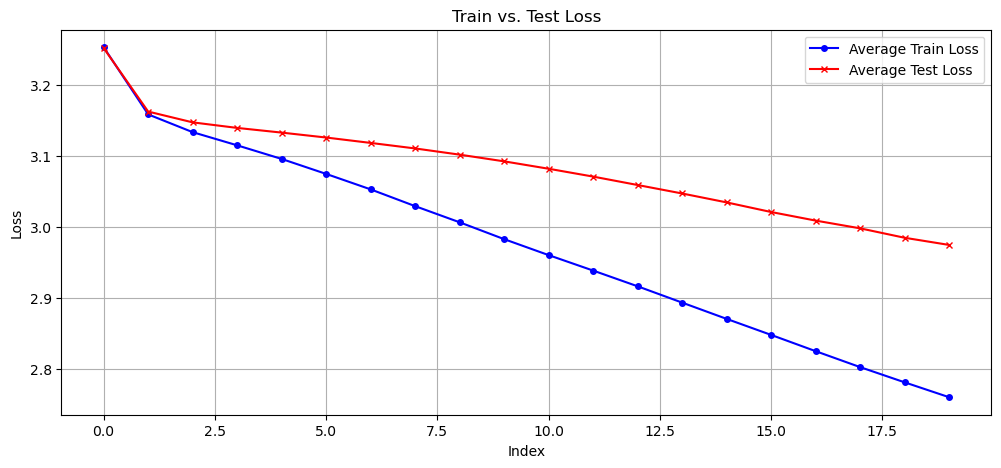

In [20]:
plot_losses(avg_train_losses,avg_test_losses)

In [21]:
def train_k_models(base_model_class,train_loaders,test_loader):
    models = []
    train_losses_list = []
    test_losses_list = []
    for i in range(len(train_loaders)):
        print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><>")
        print(f"Training model Number {i}")
        print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><>")
        model,avg_train_losses,avg_test_losses = train_and_evaluate(
        model_class=base_model_class,
        train_loader = train_loaders[i],
        test_loader=test_loader,
        d=d,
        n=n,
        device=device,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs
        )
        models.append(model)
        train_losses_list.append(avg_train_losses)
        test_losses_list.append(avg_test_losses)
        print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><>")
    return models,train_losses_list,test_losses_list

In [22]:
models,train_losses_list,test_losses_list = train_k_models(base_model_class = Base_Wasser_NN,
                                                           train_loaders = train_loaders,
                                                           test_loader = combined_test_loader)

<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Training model Number 0
<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch 1
-------------------------------
Average Train Loss: 3.2431, Average Test Loss: 3.2396
Epoch Run time: 1.89 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Train Loss: 3.1562, Average Test Loss: 3.1666
Epoch Run time: 1.89 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Train Loss: 3.1290, Average Test Loss: 3.1520
Epoch Run time: 1.96 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Train Loss: 3.1081, Average Test Loss: 3.1439
Epoch Run time: 1.89 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Train Loss: 3.0876, Average Test Loss: 3.1373
Epoch Run time: 1.94 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Train Loss: 3.0663, Average T

In [23]:
models

[Base_Wasser_NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (linear_relu_stack): Sequential(
     (Lin1): Linear(in_features=24, out_features=48, bias=True)
     (relu1): ReLU()
     (Lin2): Linear(in_features=48, out_features=48, bias=True)
   )
 ),
 Base_Wasser_NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (linear_relu_stack): Sequential(
     (Lin1): Linear(in_features=24, out_features=48, bias=True)
     (relu1): ReLU()
     (Lin2): Linear(in_features=48, out_features=48, bias=True)
   )
 ),
 Base_Wasser_NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (linear_relu_stack): Sequential(
     (Lin1): Linear(in_features=24, out_features=48, bias=True)
     (relu1): ReLU()
     (Lin2): Linear(in_features=48, out_features=48, bias=True)
   )
 ),
 Base_Wasser_NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (linear_relu_stack): Sequential(
     (Lin1): Linear(in_features=24, out_features=48, bias=True)
     (relu1): ReLU()
     (Lin2): Linear(in_features=48, out_f

# Saving models list

In [24]:
model_path = "Trained_models/Ensemble_base_estimator_Base_net_20_ep_1000_data_number_"

In [25]:
for i in range(num_estimators):
    torch.save(models[i].state_dict(), model_path+f"{i}.pt")

In [26]:
models = []
for i in range(num_estimators):
    # Loading the model
    model = Base_Wasser_NN(n=n, d=d).to(device)
    model.load_state_dict(torch.load(model_path+f"{i}.pt"))
    model.eval()
    models.append(model)
    print(f"Model {i} loaded successfully.")

Model 0 loaded successfully.
Model 1 loaded successfully.
Model 2 loaded successfully.
Model 3 loaded successfully.
Model 4 loaded successfully.


# Trying the ensemble model

In [27]:
ensemble_model = Ensemble_Wass(models)

In [28]:
ensemble_model.models

ModuleList(
  (0-4): 5 x Base_Wasser_NN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (Lin1): Linear(in_features=24, out_features=48, bias=True)
      (relu1): ReLU()
      (Lin2): Linear(in_features=48, out_features=48, bias=True)
    )
  )
)

In [29]:
def test_ensemble_model(model, dataloader):
    model.eval()
    for sub_model in model.models:
        sub_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            preds = model.predict_interval(batch)
            total_loss += np.mean([(dual.item() -primal.item()) for (dual,primal) in preds])
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [30]:
def evaluate_ensemble(model,train_loader,test_loader):
    avg_test_losses = (test_ensemble_model(model, test_loader))
    avg_train_losses = (test_ensemble_model(model, train_loader))
    print(f"Average Train Loss: {avg_train_losses:.4f}, Average Test Loss: {avg_test_losses:.4f}")



In [31]:
evaluate_ensemble(model = ensemble_model,
                 train_loader=combined_train_loader,
                 test_loader=combined_test_loader)

Average Train Loss: 2.4484, Average Test Loss: 2.5076


In [32]:
total_final_losses_test = []
for i in range(num_estimators):
    total_final_losses_test.append(np.mean(test_losses_list[i][-3:]))
print(f"Average final test loss for base estimators: {np.mean(total_final_losses_test)}")

total_final_losses_train = []
for i in range(num_estimators):
    total_final_losses_train.append(np.mean(train_losses_list[i][-3:]))
print(f"Average final train loss for base estimators: {np.mean(total_final_losses_train)}")

Average final test loss for base estimators: 2.9776655291517575
Average final train loss for base estimators: 2.7535057684580484


# Stress training

In [33]:
num_estimators = 7
count = 1500
d = 2
n = 6
seed_list = generate_random_seeds_numpy(k = num_estimators,generation_seed = 42,seed_range=(0, 120))
device = "cpu"
coords_max = 2
lr = 1e-2
batch_size = 32  # Define batch size
epochs = 50

In [34]:
# Generate lists of DataLoaders
train_loaders, test_loaders = generate_loaders_for_seeds(
    seed_list=seed_list,
    count=count,
    d=d,
    n=n,
    device=device,
    coord_max=coords_max,
    batch_size=batch_size,
    test_size=0.2
)

In [35]:
combined_train_loader = combine_dataloaders(dataloaders=train_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
combined_test_loader = combine_dataloaders(dataloaders=test_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
len(combined_train_loader.dataset),len(combined_test_loader.dataset)

(8400, 2100)

In [36]:
models,train_losses_list,test_losses_list = train_k_models(base_model_class = Base_Wasser_NN,
                                                           train_loaders = train_loaders,
                                                           test_loader = combined_test_loader)

<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Training model Number 0
<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch 1
-------------------------------
Average Train Loss: 3.1866, Average Test Loss: 3.1623
Epoch Run time: 3.17 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Train Loss: 3.1415, Average Test Loss: 3.1253
Epoch Run time: 3.11 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Train Loss: 3.1225, Average Test Loss: 3.1147
Epoch Run time: 3.06 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Train Loss: 3.1053, Average Test Loss: 3.1048
Epoch Run time: 3.15 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Train Loss: 3.0810, Average Test Loss: 3.0942
Epoch Run time: 3.07 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Train Loss: 3.0501, Average T

# Saving and loading models

In [37]:
model_path = "Trained_models/Ensemble_base_estimator_Base_net_50_ep_1500_data_number_"

In [38]:
for i in range(num_estimators):
    torch.save(models[i].state_dict(), model_path+f"{i}.pt")

In [39]:
models = []
for i in range(num_estimators):
    # Loading the model
    model = Base_Wasser_NN(n=n, d=d).to(device)
    model.load_state_dict(torch.load(model_path+f"{i}.pt"))
    model.eval()
    models.append(model)
    print(f"Model {i} loaded successfully.")

Model 0 loaded successfully.
Model 1 loaded successfully.
Model 2 loaded successfully.
Model 3 loaded successfully.
Model 4 loaded successfully.
Model 5 loaded successfully.
Model 6 loaded successfully.


In [40]:
ensemble_model = Ensemble_Wass(models)
ensemble_model.models

ModuleList(
  (0-6): 7 x Base_Wasser_NN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (Lin1): Linear(in_features=24, out_features=48, bias=True)
      (relu1): ReLU()
      (Lin2): Linear(in_features=48, out_features=48, bias=True)
    )
  )
)

In [41]:
evaluate_ensemble(model = ensemble_model,
                 train_loader=combined_train_loader,
                 test_loader=combined_test_loader)

Average Train Loss: 1.7947, Average Test Loss: 1.8594


In [42]:
total_final_losses_test = []
for i in range(num_estimators):
    total_final_losses_test.append(np.mean(test_losses_list[i][-3:]))
print(f"Average final test loss for base estimators: {np.mean(total_final_losses_test)}")

total_final_losses_train = []
for i in range(num_estimators):
    total_final_losses_train.append(np.mean(train_losses_list[i][-3:]))
print(f"Average final train loss for base estimators: {np.mean(total_final_losses_train)}")

Average final test loss for base estimators: 2.5224134221909535
Average final train loss for base estimators: 2.185390482122139


# More stress testing (Many good learners)

In [43]:
num_estimators = 3
count = 5000
d = 2
n = 6
seed_list = generate_random_seeds_numpy(k = num_estimators,generation_seed = 42,seed_range=(0, 120))
device = "cpu"
coords_max = 2
lr = 1e-2
batch_size = 64  # Define batch size
epochs = 120

In [44]:
# Generate lists of DataLoaders
train_loaders, test_loaders = generate_loaders_for_seeds(
    seed_list=seed_list,
    count=count,
    d=d,
    n=n,
    device=device,
    coord_max=coords_max,
    batch_size=batch_size,
    test_size=0.2
)
combined_train_loader = combine_dataloaders(dataloaders=train_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
combined_test_loader = combine_dataloaders(dataloaders=test_loaders,
                                            batch_size=batch_size,
                                            shuffle=False)
len(combined_train_loader.dataset),len(combined_test_loader.dataset)

(12000, 3000)

In [46]:
models,train_losses_list,test_losses_list = train_k_models(base_model_class = Base_Wasser_NN,
                                                           train_loaders = train_loaders,
                                                           test_loader = combined_test_loader)

<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Training model Number 0
<><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch 1
-------------------------------
Average Train Loss: 3.1397, Average Test Loss: 3.1304
Epoch Run time: 9.29 seconds.

-------------------------------
Epoch 2
-------------------------------
Average Train Loss: 3.1138, Average Test Loss: 3.1101
Epoch Run time: 9.23 seconds.

-------------------------------
Epoch 3
-------------------------------
Average Train Loss: 3.0901, Average Test Loss: 3.0935
Epoch Run time: 9.11 seconds.

-------------------------------
Epoch 4
-------------------------------
Average Train Loss: 3.0637, Average Test Loss: 3.0758
Epoch Run time: 9.05 seconds.

-------------------------------
Epoch 5
-------------------------------
Average Train Loss: 3.0334, Average Test Loss: 3.0547
Epoch Run time: 9.08 seconds.

-------------------------------
Epoch 6
-------------------------------
Average Train Loss: 2.9978, Average T

In [47]:
len(models)

3

# Saving and loading models

In [48]:
model_path = "Trained_models/Ensemble_base_estimator_Base_net_120_ep_3000_data_number_"

In [49]:
for i in range(num_estimators):
    torch.save(models[i].state_dict(), model_path+f"{i}.pt")

In [50]:
models = []
for i in range(num_estimators):
    # Loading the model
    model = Base_Wasser_NN(n=n, d=d).to(device)
    model.load_state_dict(torch.load(model_path+f"{i}.pt"))
    model.eval()
    models.append(model)
    print(f"Model {i} loaded successfully.")

Model 0 loaded successfully.
Model 1 loaded successfully.
Model 2 loaded successfully.


In [51]:
ensemble_model = Ensemble_Wass(models)
ensemble_model.models

ModuleList(
  (0-2): 3 x Base_Wasser_NN(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_relu_stack): Sequential(
      (Lin1): Linear(in_features=24, out_features=48, bias=True)
      (relu1): ReLU()
      (Lin2): Linear(in_features=48, out_features=48, bias=True)
    )
  )
)

# Evaluation

In [52]:
evaluate_ensemble(model = ensemble_model,
                 train_loader=combined_train_loader,
                 test_loader=combined_test_loader)

Average Train Loss: 1.6230, Average Test Loss: 1.7014


In [53]:
total_final_losses_test = []
for i in range(num_estimators):
    total_final_losses_test.append(np.mean(test_losses_list[i][-3:]))
print(f"Average final test loss for base estimators: {np.mean(total_final_losses_test)}")

total_final_losses_train = []
for i in range(num_estimators):
    total_final_losses_train.append(np.mean(train_losses_list[i][-3:]))
print(f"Average final train loss for base estimators: {np.mean(total_final_losses_train)}")

Average final test loss for base estimators: 2.0968761156636773
Average final train loss for base estimators: 1.8662899120774847
